In [1]:
! pip install pmdarima

     |████████████████████████████████| 1.4 MB 586 kB/s            


In [2]:
from pmdarima.arima import auto_arima

In [3]:
import numpy as np
import pandas as pd
import warnings
#import gc
from tqdm.auto import tqdm
import datetime as dt
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings('ignore')

# Import Data

In [4]:
# Import
train = pd.read_csv("../input/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("../input/store-sales-time-series-forecasting/test.csv")
zero_prediction = pd.read_csv("../input/zero-prediction/zero_prediction.csv")

# Datetime
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)

zero_prediction = zero_prediction.set_index(['store_nbr', 'family', 'date']).sort_index()

# Validation

In [5]:
train_df = train[train.date<'2017-08-01'].copy()
val_df = train[train.date>'2017-08-01'].copy()

# Метрики

In [6]:
def compute_metrics(real, forecast):
    result = {}
    real=np.array(real)
    forecast=np.array(forecast)
    result['MSE'] = round(((real-forecast)**2).mean(),4)
    result['RMSE'] = round((((real-forecast)**2)**(1/2)).mean(),4)
    mape_list = []
    smap_list = []
    for i in range(len(real)):
        if real[i] == 0:
            mape_list.append(0)
            smap_list.append(0)
        else:
            mape_list.append(abs(real[i]-forecast[i])/real[i])
            smap_list.append(2.0 * np.mean(np.abs(forecast[i] - real[i]) / (np.abs(forecast[i]) + np.abs(real[i]))))
        
    result['MAPE'] = round(np.mean(mape_list),4)
    result['SMAP'] = round(np.mean(smap_list),4)                   
    # result['SMAP'] = round(2.0 * np.mean(np.abs(forecast - real) / (np.abs(forecast) + np.abs(real))),4)
    return pd.Series(result)

# Определение характера временного ряда

Вообще говоря, мы имеем целый набор временных рядов. Посмотрим на общий паттерн, а затем просмотрим прицельно на нескоторые данные.

<AxesSubplot:title={'center':'sales - year'}, xlabel='year'>

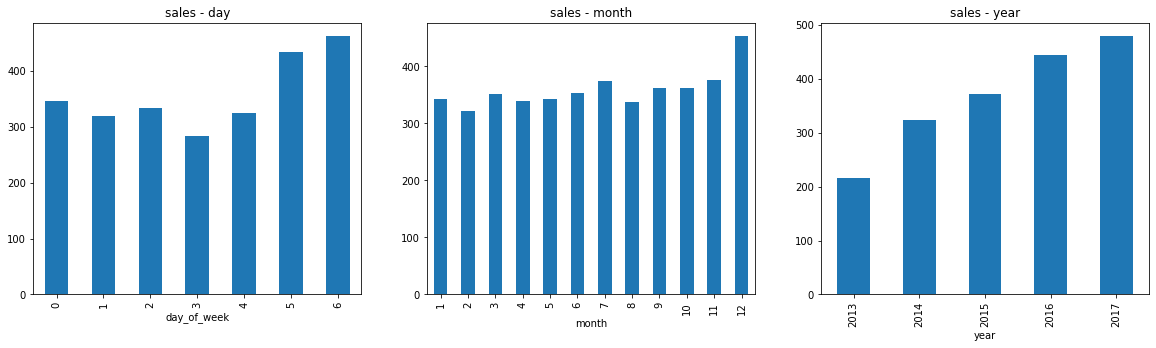

In [7]:
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

data_grouped_day = train.groupby(['day_of_week']).mean()['sales']
data_grouped_month = train.groupby(['month']).mean()['sales']
data_grouped_year = train.groupby(['year']).mean()['sales']

plt.subplots(3,1, figsize=(20,5))
plt.subplot(131)
plt.title('sales - day')
data_grouped_day.plot(kind='bar', stacked=True)
plt.subplot(132)
plt.title('sales - month')
data_grouped_month.plot(kind='bar', stacked=True)
plt.subplot(133)
plt.title('sales - year')
data_grouped_year.plot(kind='bar', stacked=True)

По общим данным видим, что                      
- есть недельная сезонность: в субботу и воскресенье в целом больше продаж, чем в будни;
- есть сезонность по месяцам: в декабре продаж ощутимо больше, чем в другие месяцы;
- есть стабильный рост объема продаж от года к году. 

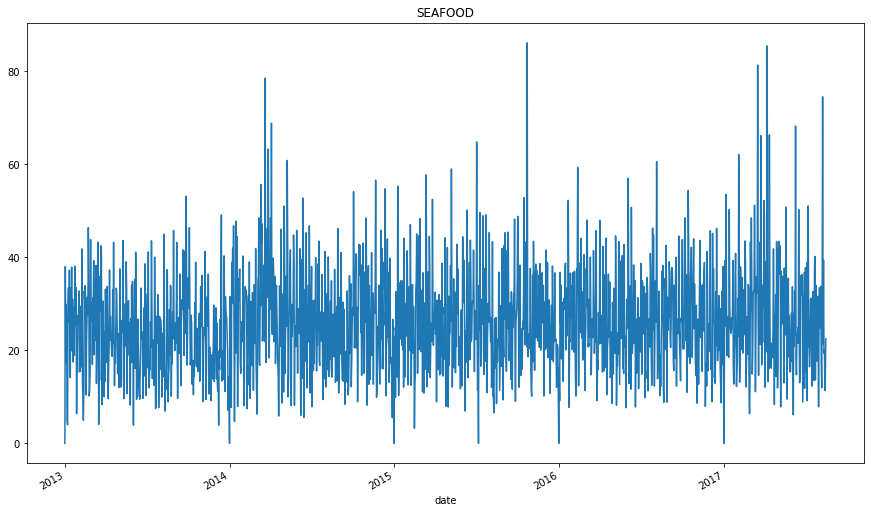

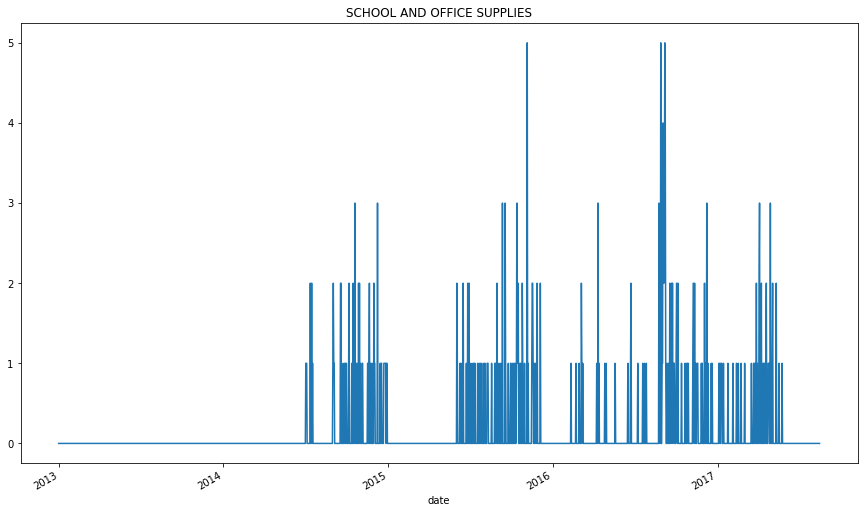

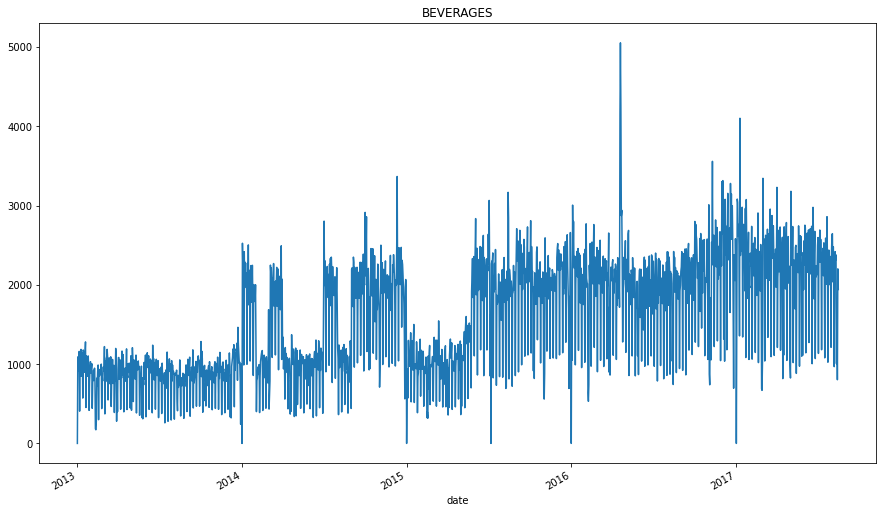

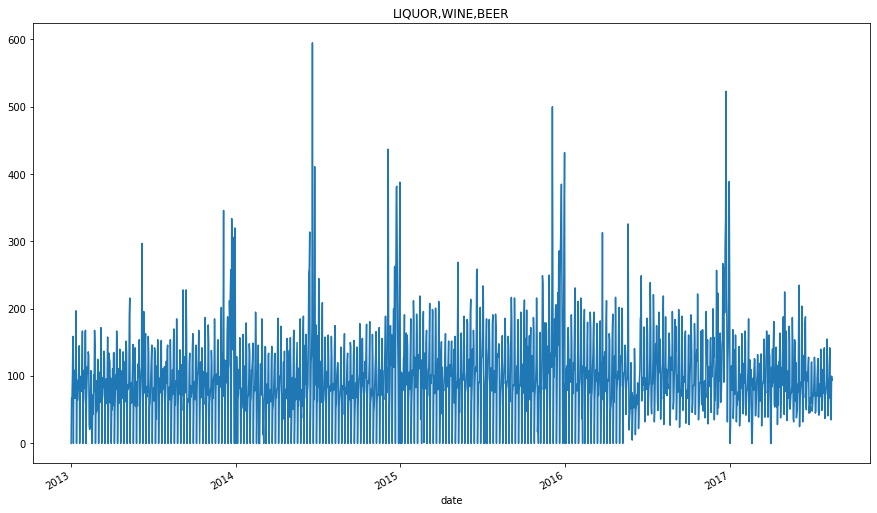

In [8]:
nbr=1
family = ['SEAFOOD', 'SCHOOL AND OFFICE SUPPLIES', 'BEVERAGES', 'LIQUOR,WINE,BEER']

for fam in family:
    viz = train[(train.store_nbr == nbr) & (train.family == fam)].copy()
    viz=viz.set_index('date')
    plt.rcParams['figure.figsize'] = (15, 9)
    plt.figure()
    plt.title(fam)
    viz.sales.plot()
    plt.show()

Сезонность визуально определима не во всех категориях товаров.

# Тест на стационарность

In [9]:
from pmdarima.arima import ADFTest

In [10]:
# Удаляем нулевые продажи из данных
c = train.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
c = c[c.sales == 0]
outer_join = train.merge(c[c.sales == 0].drop("sales",axis = 1), how = 'outer', indicator = True)
train = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)

In [11]:
# fuller_not_stat = pd.DataFrame(columns = ['store_nbr', 'family'])

# for num, store in enumerate(tqdm(train.store_nbr.unique())):
#     for numf, fam in enumerate(tqdm(train.family.unique())):
#         a=train[(train.store_nbr == store) & (train.family == fam)]
#         try:
#             adf_test = ADFTest(alpha = 0.05)
#             test_result = adf_test.should_diff(a.set_index('date').sales)
#             # print('adf: ', test_result)
#             if test_result[0]>0.05:
#                 print('Магазин: ', store, 'семейство товаров: ', fam)
#                 print('adf: ', test_result)
#                 print('Добавляем в список')
#                 fuller_not_stat = fuller_not_stat.append({'store_nbr':store, 'family':fam}, ignore_index=True)
#                 print('___'*20)
#             else:
#                 continue
#                 #print('___'*20)
#         except:
#                 continue
#                 #print('___'*20)
                

In [12]:
# fuller_not_stat.to_csv('fuller_not_stat.csv', index=False)

In [13]:
# need_second_diff = pd.DataFrame(columns = ['store_nbr', 'family'])
# for num, store in enumerate(tqdm(fuller_not_stat.store_nbr.unique())):
#     for numf, fam in enumerate(tqdm(fuller_not_stat.family.unique())):
#         a=train[(train.store_nbr == store) & (train.family == fam)]
#         try:
#             adf_test = ADFTest(alpha = 0.05)
#             test_result = adf_test.should_diff(a.set_index('date').sales.diff().dropna())
#             # print('adf: ', test_result)
#             if test_result[0]>0.05:
#                 print('Магазин: ', store, 'семейство товаров: ', fam)
#                 print('adf: ', test_result)
#                 print('Добавляем в список')
#                 need_second_diff = need_second_diff.append({'store_nbr':store, 'family':fam}, ignore_index=True)
#                 print('___'*20)
#             else:
#                 continue
#                 #print('___'*20)
#         except:
#                 continue
#                 #print('___'*20)

Вторые разности не потребовались. Все ряды стационарны при первой разности.

# ARIMA

Сезонная ARIMA зависит от значений p, d, q:

p - количество лагов, параметр AR;                   
d - порядок разности;                    
q - количество запаздывающих ошибок прогноза, параметр MA.               
                                   
а также сезонных составляющих P, D, Q:                     
                               
P - порядок сезонной компоненты для AR;
D - порядок интегрирования сезонного процесса;
Q - порядок сезонной компоненты для МА.                                   
                     
**aic** (информационный критерий Акаике):             
- более низкий aic указывает на лучшую модель;             
- aic выбирет простые модели с более низким порядком.

In [14]:
# Ограничим тренировочные данные 2017 годом
to_train = train_df[train_df.date>'2017-01-01'].copy()

In [15]:
for num, store in enumerate(tqdm(to_train.store_nbr.unique())):
    for numf, fam in enumerate(tqdm(to_train.family.unique())):
        a=to_train[(to_train.store_nbr == store) & (to_train.family == fam)].set_index('date')
        
        arima_model = auto_arima(a.sales, start_p = 0, d=1, start_q=0, 
                            max_p=2, max_d=1, max_q=2, 
                            start_P=0, D=1, start_Q=0, 
                            max_P=3, max_Q=1,
                            seasonal = True, #error_action='warn', #trace=True, surpress_warnings=True, 
                            stepwise=True, random_state=20, n_fits=50)
        prediction = arima_model.predict(n_periods = 30)
        val_df.loc[(val_df.store_nbr == store) & (val_df.family == fam), 'arima'] = prediction[:14]
        test.loc[(test.store_nbr == store) & (test.family == fam), 'arima'] = prediction[14:]
        

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

In [16]:
compute_metrics(val_df.sales, val_df.arima)   

MSE     121875.7848
RMSE       109.7259
MAPE         0.4233
SMAP         0.3254
dtype: float64

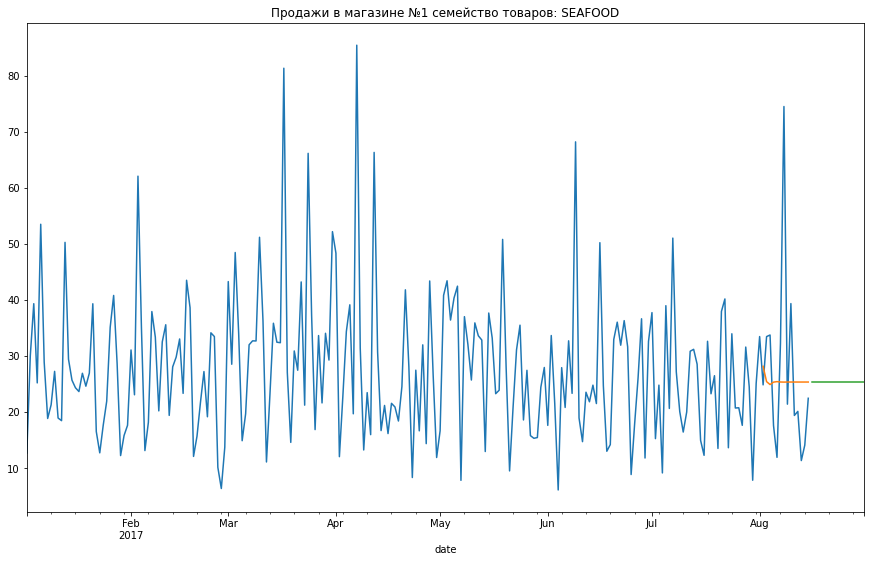

In [17]:
nbr=1
family = 'SEAFOOD'
train_viz = train[train.date>'2017-01-01'].copy()
train_viz = train_viz[(train_viz.store_nbr == nbr) & (train_viz.family == family)]
train_viz = train_viz.set_index('date')
val_viz = val_df.loc[(val_df.store_nbr == nbr) & (val_df.family == family)]
val_viz = val_viz.set_index('date')
test_viz = test.loc[(test.store_nbr == nbr) & (test.family == family)]
test_viz = test_viz.set_index('date')

plt.rcParams['figure.figsize'] = (15, 9)
plt.figure()
train_viz.sales.plot()
val_viz.arima.plot()
test_viz.arima.plot()
plt.title('Продажи в магазине №'+str(nbr)+' семейство товаров: '+family)
plt.show()

# Submit for ARIMA

In [18]:
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()
for i in zero_prediction.index:
    test.loc[i,'arima']=0

In [19]:
test=test.reset_index()
y_submit = test[['id','arima']].copy()
y_submit['arima'] = y_submit.arima.clip(0)
y_submit.columns = ['id', 'sales']
y_submit.to_csv('submission_arima.csv', index=False)

In [20]:
y_submit.tail()

,id,sales
28507,3022139,2.913388
28508,3023921,2.913388
28509,3025703,2.913388
28510,3027485,2.913388
28511,3029267,2.913388


**Результат на kaggle 0.5472**

# Модель Хольта-Винтерса

In [21]:
from statsmodels.tsa.api import ExponentialSmoothing

In [22]:
for num, store in enumerate(tqdm(train_df.store_nbr.unique())):
    for numf, fam in enumerate(tqdm(train_df.family.unique())):
        a = train_df[(train_df.store_nbr == store) & (train_df.family == fam)].copy()
        if len(a)!=0:
            model_HW = ExponentialSmoothing(a.sales, seasonal_periods=7, trend='add', seasonal='add').fit()
            prediction = np.array(model_HW.forecast(30))
            val_df.loc[(val_df.store_nbr == store) & (val_df.family == fam), 'HW_pred'] = prediction[:14]
            test.loc[(test.store_nbr == store) & (test.family == fam),'HW_pred']=prediction[14:]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

In [23]:
compute_metrics(val_df.sales, val_df.HW_pred)

MSE     211433.3702
RMSE       132.4616
MAPE         0.4413
SMAP         0.3466
dtype: float64

In [24]:
val_df['difference'] = val_df.HW_pred - val_df.sales

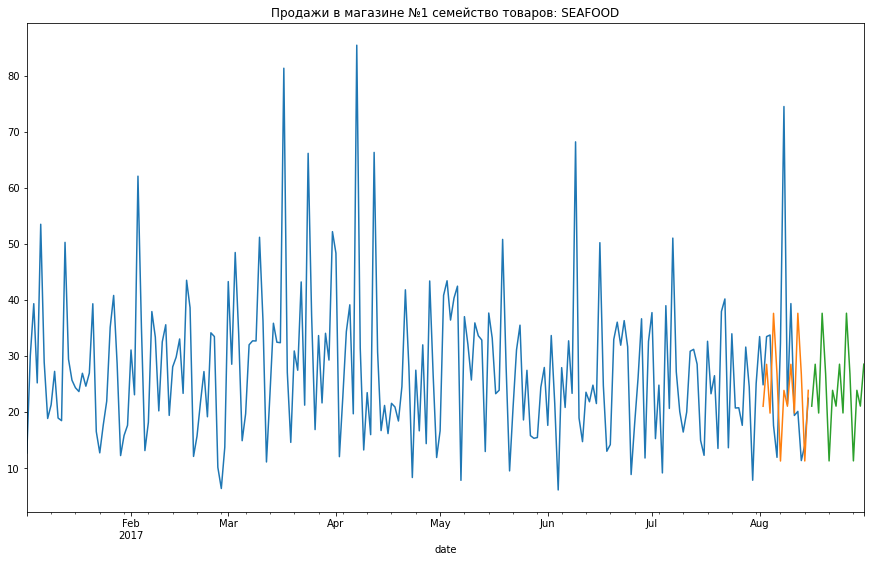

In [25]:
nbr=1
family = 'SEAFOOD'
train_viz = train[train.date>'2017-01-01'].copy()
train_viz = train_viz[(train_viz.store_nbr == nbr) & (train_viz.family == family)]
train_viz = train_viz.set_index('date')
val_viz = val_df.loc[(val_df.store_nbr == nbr) & (val_df.family == family)]
val_viz = val_viz.set_index('date')
test_viz = test.loc[(test.store_nbr == nbr) & (test.family == family)]
test_viz = test_viz.set_index('date')

plt.rcParams['figure.figsize'] = (15, 9)
plt.figure()
train_viz.sales.plot()
val_viz.HW_pred.plot()
test_viz.HW_pred.plot()
plt.title('Продажи в магазине №'+str(nbr)+' семейство товаров: '+family)
plt.show()

# Submit for Holt-Winters

In [26]:
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()
for i in zero_prediction.index:
    test.loc[i,'HW_pred']=0

In [27]:
test=test.reset_index()
y_HW_submit = test[['id','HW_pred']].copy()
# y_HW_submit['HW_pred'] = y_HW_submit.HW_pred.clip(0)
y_HW_submit.columns = ['id', 'sales']
y_HW_submit.to_csv('submission_HW_pred.csv', index=False)

In [28]:
y_HW_submit.tail()

,id,sales
28507,3022139,3.336252
28508,3023921,3.560043
28509,3025703,3.736478
28510,3027485,3.637568
28511,3029267,3.738743
